# Final Project - Reinforcements Learning
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Ilai Av-Ron 318918547
<br>
Student 2: Itay Basson 209040005
<br>
Student 3: Reef Fogel 318320827
<br>
<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

### https://github.com/mpSchrader/gym-sokoban

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban

# Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
from base64 import b64encode
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import copy
from gym.spaces import Box
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.vec_env import VecEnv
from stable_baselines3.common.vec_env.patch_gym import _patch_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecTransposeImage


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4_1(filename):
    """Embeds an MP4 file in the notebook."""
    video = open(filename, "rb").read()
    b64_video = b64encode(video).decode()
    video_tag = f'<video width="640" height="480" controls><source src="data:video/mp4;base64,{b64_video}" type="video/mp4"></video>'
    return HTML(video_tag)

In [ ]:
def video_test_ex1(agent):
  random.seed(2)
  sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
  observation = sok.render('rgb_array')
  agent.env = sok
  start_time = time.time()
  done = False
  iter = 0
  video_filename = 'imageio.mp4'


  with imageio.get_writer(video_filename, fps=10) as video:
    video.append_data(sok.render(mode='rgb_array'))
    while (iter < 10) or not done:
      time_passed = int(time.time() - start_time)
      if done or time_passed > 3:
        break
      iter +=1
      state = agent.env.render('tiny_rgb_array')
      action = agent.choose_action(state)
      observation, reward, done, info = agent.env.step(action)
      video.append_data(agent.env.render(mode='rgb_array'))

  return embed_mp4_1(video_filename)

In [ ]:
def video_test_ex2(agent, env=None):
    if env is None:
        env = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1, max_steps=500)

    observation = env.reset()
    start_time = time.time()
    done = False
    iter = 0
    video_filename = 'imageio.mp4'

    with imageio.get_writer(video_filename, fps=10) as video:
        video.append_data(env.render(mode='rgb_array'))
        while not done:
            time_passed = int(time.time() - start_time)
            if time_passed > 3:
                break
            iter += 1
            action, _states = agent.predict(observation)
            action = action.item()  # Convert numpy array to scalar
            observation, reward, done, info = env.step(action)
            video.append_data(env.render(mode='rgb_array'))

    return embed_mp4_1(video_filename)

Function - given an environment it will print us the details about observation, actions, agent's position and boxes locations

In [ ]:
def print_env_det(env):
  print(f'Observation space: {env.observation_space}'
      f'\nAction space: {env.action_space}'
      f'\nPlayer position:{env.player_position}'
      f'\nBox location: {find_box_location(env)}')

Function - given an environment it will return the indexes position and boxes locations

In [ ]:
def find_box_location(env):
    idx = np.argmax(env.room_state == 4)
    if env.room_state.flat[idx] == 4:
        return np.unravel_index(idx, env.room_state.shape)
    return None

def find_player_location(env):
    idx = np.argmax(env.room_state == 5)
    if env.room_state.flat[idx] == 5:
        return np.unravel_index(idx, env.room_state.shape)
    return None

def find_target_location(env):
    idx = np.argmax(env.room_state == 2)
    if env.room_state.flat[idx] == 2:
        return np.unravel_index(idx, env.room_state.shape)
    return None

# Feeling the Env

Initial thought:

- Negative rewards for doing nothing.
- Slightly less negative rewards for moving.
- Least negative rewards for moving the box.
- Huge positive value for inserting the box into the target.


Another idea:

- After n steps (when we want to finish), calculate the distance of the box from its target.
- Map {max_distance, 0} to {large negative value, 0}

[[[176  61   0]
  [176  61   0]
  [176  61   0]
  ...
  [176  61   0]
  [176  61   0]
  [176  61   0]]

 [[176  61   0]
  [176  61   0]
  [176  61   0]
  ...
  [176  61   0]
  [176  61   0]
  [176  61   0]]

 [[176  61   0]
  [176  61   0]
  [176  61   0]
  ...
  [176  61   0]
  [176  61   0]
  [176  61   0]]

 ...

 [[176  61   0]
  [176  61   0]
  [176  61   0]
  ...
  [176  61   0]
  [176  61   0]
  [176  61   0]]

 [[176  61   0]
  [176  61   0]
  [176  61   0]
  ...
  [176  61   0]
  [176  61   0]
  [176  61   0]]

 [[176  61   0]
  [176  61   0]
  [176  61   0]
  ...
  [176  61   0]
  [176  61   0]
  [176  61   0]]]
Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[2 1]
Box location: (2, 2)


(array([[0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 0, 0],
        [0, 1, 1, 2, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 0, 0],
        [0, 1, 1, 2, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 4, 5, 0],
        [0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]),
 {(2, 3): (4, 4)})

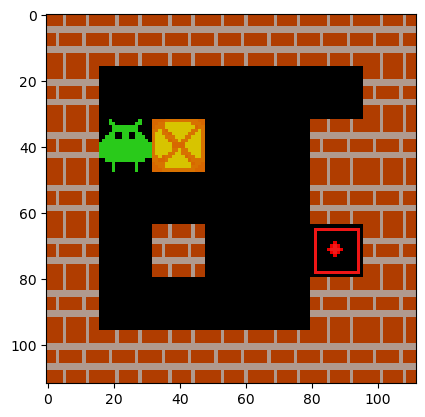

In [ ]:
random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
screen = sok.render(mode='rgb_array')
print(screen)
plt.imshow(sok.render('rgb_array'))
print_env_det(sok)
generate_room(
                    dim=sok.dim_room,
                    num_steps=sok.num_gen_steps,
                    num_boxes=sok.num_boxes,
                )

## EX1 - FIX SCENARIO -  PUSH & PULL - ONE BOX

explanation in the report

In [ ]:
#=============== DO NOT DELETE ===============
random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95, epsilon=0.5, epsilon_decay=0.99, change_threshold=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.q_table = {}
        self.change_threshold = change_threshold
        self.max_steps_per_episode = 500
        self.stable_count_threshold = 20

    def choose_action(self, state):
        state_key = tuple(state.ravel())
        if np.random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.q_table.get(state_key, np.zeros(self.env.action_space.n)))
        return action

    def learn(self, state, action, reward, next_state):
        state_key = tuple(state.ravel())
        next_state_key = tuple(next_state.ravel())
        old_value = self.q_table.get(state_key, np.zeros(self.env.action_space.n))[action]

        q_predict = old_value
        q_target = reward + self.discount_factor * np.max(self.q_table.get(next_state_key, np.zeros(self.env.action_space.n)))

        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.env.action_space.n)

        new_value = old_value + self.learning_rate * (q_target - q_predict)
        self.q_table[state_key][action] = new_value
        return abs(new_value - old_value)

    def copy(self):
      new_agent = QLearningAgent(self.env, self.learning_rate, self.discount_factor, self.epsilon, self.epsilon_decay, self.change_threshold)
      new_agent.q_table = {k: v.copy() for k, v in self.q_table.items()}
      return new_agent

    def train(self, episodes):
        changes = []
        stable_count = 0
        for episode in range(episodes):
            if episode == 50:
              agent_50 = self.copy()
            if episode == 125:
              agent_125 = self.copy()
            total_reward = 0
            steps = 0
            random.seed(2)
            self.env = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
            state = self.env.render('tiny_rgb_array')
            done = False
            episode_change = 0
            while not done and steps < self.max_steps_per_episode:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.env.render('tiny_rgb_array').flatten()
                change = self.learn(state, action, reward, next_state)
                episode_change += change
                state = next_state
                steps += 1
                total_reward += reward

            changes.append(episode_change)
            if episode > 0 and abs(changes[-1] - changes[-2]) < self.change_threshold:
                stable_count += 1
            else:
                stable_count = 0

            if stable_count >= self.stable_count_threshold:
                print(f"Training stopped early at episode {episode + 1} due to minimal Q-table changes.")
                break

            self.epsilon *= self.epsilon_decay
            print(f"Episode {episode + 1}, Total Steps: {steps}, Total Reward: {total_reward}, Change: {episode_change}")

        self.converged_episode = episode + 1
        print("Training finished.")
        return agent_50, agent_125
agent = QLearningAgent(sok)
agent_50, agent_125 = agent.train(episodes=300)

Episode 1, Total Steps: 466, Total Reward: -35.60000000000039, Change: 5.653479999999954
Episode 2, Total Steps: 500, Total Reward: -50.00000000000044, Change: 4.880152974999969
Episode 3, Total Steps: 500, Total Reward: -50.00000000000044, Change: 4.879934999999958
Episode 4, Total Steps: 500, Total Reward: -50.00000000000044, Change: 4.834214727499969
Episode 5, Total Steps: 500, Total Reward: -50.00000000000044, Change: 4.893319999999951
Episode 6, Total Steps: 185, Total Reward: -7.499999999999991, Change: 2.840479705000001
Episode 7, Total Steps: 500, Total Reward: -50.00000000000044, Change: 4.848258999999965
Episode 8, Total Steps: 500, Total Reward: -50.00000000000044, Change: 4.813454070499968
Episode 9, Total Steps: 500, Total Reward: -50.00000000000044, Change: 4.792614405999977
Episode 10, Total Steps: 500, Total Reward: -50.00000000000044, Change: 4.8417327999999635
Episode 11, Total Steps: 294, Total Reward: -18.400000000000148, Change: 4.0682639134999885
Episode 12, Tota

**self written video test and analytics**

In [ ]:

html_video_50 = video_test_ex1(agent_50)
html_video_125 = video_test_ex1(agent_125)
html_video = video_test_ex1(agent)

Agent after 50 episodes

In [ ]:
html_video_50

agent after 125 episodes

In [ ]:
html_video_125

fully trained agent

In [ ]:
html_video

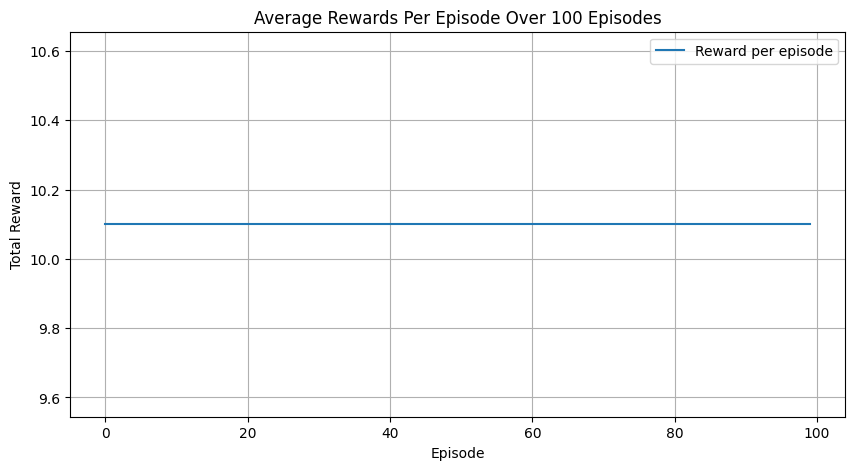

In [ ]:
def collect_rewards(agent, episodes=100):
    reward_list = []
    for _ in range(episodes):
        total_reward = 0
        random.seed(2)
        agent.env = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
        state = agent.env.render('tiny_rgb_array')
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = agent.env.step(action)
            next_state = agent.env.render('tiny_rgb_array')
            state = next_state
            total_reward += reward
        reward_list.append(total_reward)
    return reward_list

def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Reward per episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Average Rewards Per Episode Over 100 Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Collect rewards data
rewards = collect_rewards(agent, 100)

# Plot the rewards
plot_rewards(rewards)

Episode 1, Total Steps: 120, Total Reward: -0.9999999999999734, Change: 1.1396375000000005
Episode 2, Total Steps: 500, Total Reward: -50.00000000000044, Change: 2.4943243749999704
Episode 3, Total Steps: 500, Total Reward: -50.00000000000044, Change: 2.4943624999999727
Episode 4, Total Steps: 500, Total Reward: -50.00000000000044, Change: 2.491663812499975
Episode 5, Total Steps: 500, Total Reward: -50.00000000000044, Change: 2.4922506249999716
Episode 6, Total Steps: 500, Total Reward: -50.00000000000044, Change: 2.4886416249999788
Episode 7, Total Steps: 471, Total Reward: -36.1000000000004, Change: 2.8738253749999787
Episode 8, Total Steps: 500, Total Reward: -50.00000000000044, Change: 2.4877430609374835
Episode 9, Total Steps: 500, Total Reward: -50.00000000000044, Change: 2.4826768671874895
Episode 10, Total Steps: 500, Total Reward: -50.00000000000044, Change: 2.4822413943857184
Episode 11, Total Steps: 500, Total Reward: -50.00000000000044, Change: 2.4863222387499877
Episode 1

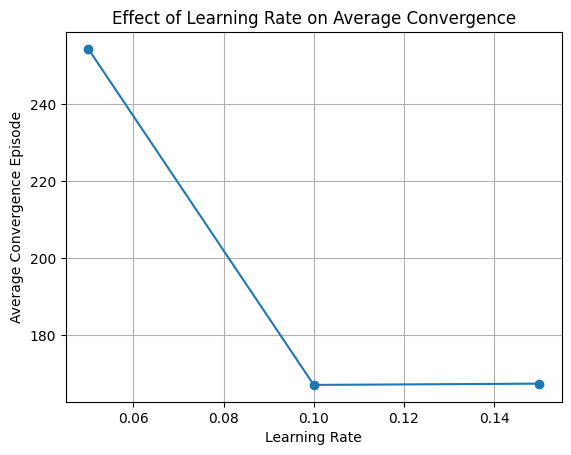

In [ ]:
def run_learning_rate_experiment(learning_rates, num_runs=3):
    average_convergence_episodes = []
    for lr in learning_rates:
        episodes_for_lr = []
        for _ in range(num_runs):
            agent = QLearningAgent(env=sok, learning_rate=lr, discount_factor=0.95, epsilon=0.1, epsilon_decay=0.99, change_threshold=0.01)
            agent.train(300)
            episodes_for_lr.append(agent.converged_episode)
        average_convergence_episodes.append(np.mean(episodes_for_lr))
    return learning_rates, average_convergence_episodes

# Learning rate values to test
learning_rates = [0.05, 0.1, 0.15]
lrs, avg_episodes = run_learning_rate_experiment(learning_rates)

# Plotting the results
plt.figure()
plt.plot(lrs, avg_episodes, marker='o')
plt.title('Effect of Learning Rate on Average Convergence')
plt.xlabel('Learning Rate')
plt.ylabel('Average Convergence Episode')
plt.grid(True)
plt.show()

Training stopped early at episode 208 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 202 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 213 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 216 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 198 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 158 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 215 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 212 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 141 due to minimal Q-table changes.
Training finished.


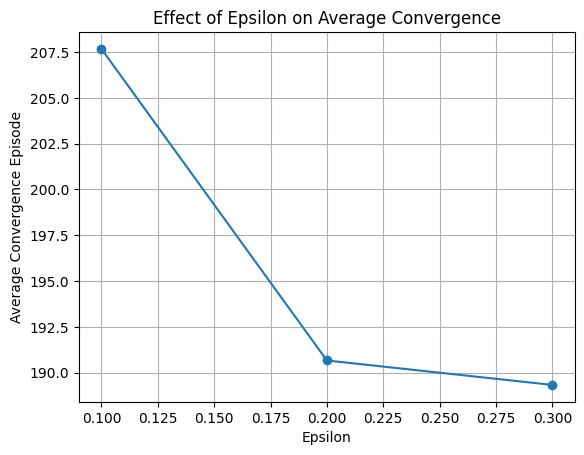

In [ ]:
def run_epsilon_experiment(epsilons, num_runs=3):
    average_convergence_episodes = []
    for eps in epsilons:
        episodes_for_eps = []
        for _ in range(num_runs):
            agent = QLearningAgent(env=sok, learning_rate=0.1, discount_factor=0.95, epsilon=eps, epsilon_decay=0.99, change_threshold=0.01)
            agent.train(300)
            episodes_for_eps.append(agent.converged_episode)
        average_convergence_episodes.append(np.mean(episodes_for_eps))
    return epsilons, average_convergence_episodes

# Epsilon values to test
epsilons = [0.1, 0.2, 0.3]
epss, avg_episodes = run_epsilon_experiment(epsilons)

# Plotting the results
plt.figure()
plt.plot(epss, avg_episodes, marker='o')
plt.title('Effect of Epsilon on Average Convergence')
plt.xlabel('Epsilon')
plt.ylabel('Average Convergence Episode')
plt.grid(True)
plt.show()

Training stopped early at episode 159 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 170 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 157 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 212 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 210 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 143 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 221 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 141 due to minimal Q-table changes.
Training finished.
Training stopped early at episode 228 due to minimal Q-table changes.
Training finished.


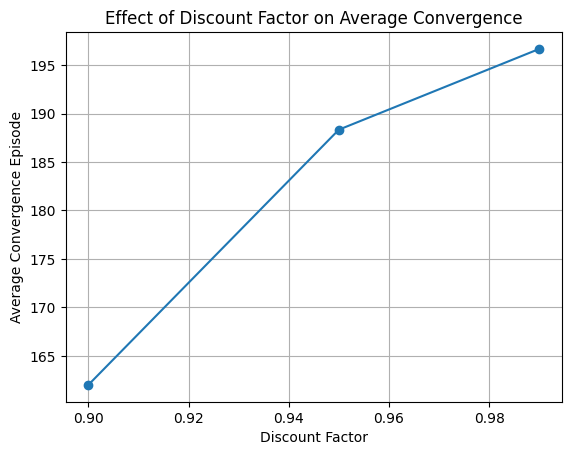

In [ ]:
def run_discount_factor_experiment(discount_factors, num_runs=3):
    average_convergence_episodes = []
    for df in discount_factors:
        episodes_for_df = []
        for _ in range(num_runs):
            agent = QLearningAgent(env=sok, learning_rate=0.1, discount_factor=df, epsilon=0.1, epsilon_decay=0.99, change_threshold=0.01)
            agent.train(300)
            episodes_for_df.append(agent.converged_episode)
        average_convergence_episodes.append(np.mean(episodes_for_df))
    return discount_factors, average_convergence_episodes

# Discount factor values to test
discount_factors = [0.9, 0.95, 0.99]
dfs, avg_episodes = run_discount_factor_experiment(discount_factors)

# Plotting the results
plt.figure()
plt.plot(dfs, avg_episodes, marker='o')
plt.title('Effect of Discount Factor on Average Convergence')
plt.xlabel('Discount Factor')
plt.ylabel('Average Convergence Episode')
plt.grid(True)
plt.show()

## EX2 - PUSH & PULL - ONE BOX

explanation in the report

In [ ]:
#=============== DO NOT DELETE ===============
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

In [ ]:
class DQNAgent:
    def __init__(self, env, state_dim, action_dim, learning_rate=0.001, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01):
        self.env = env
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.discount_factor = discount_factor
        self.visited_states = set()
        self.memory = deque(maxlen=10000)

        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_values = self.model(state)
        return np.argmax(action_values.cpu().data.numpy())

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = reward
            if not done:
                target = reward + self.discount_factor * torch.max(self.model(next_state).detach())
            current_q = self.model(state)[action]
            loss = self.criterion(current_q, torch.tensor(target))

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def reward_shaping(self, action, box_location, new_box_location, player_location, new_player_location, box_target, reward):

        # if next_state not in self.visited_states:
        #     reward += 0.05
        #     self.visited_states.add(next_state)

        # print(f"action:  {action}")
        # print(f"box_location: {box_location}")
        # print(f"new_box_location: {new_box_location}")
        # print(f"box_target: {box_target}")
        # print(f"player_location: {player_location}")
        # print(f"new_player_location: {new_player_location}")


        if box_location is None:
            box_location = box_target

        if box_target is None:
            box_target = box_location

        if new_box_location is None:
            new_box_location = box_target

        current_box_distance = np.sum(np.abs(np.array(box_location) - np.array(box_target)))
        # print(f"current box distance: {current_box_distance}")
        new_box_distance = np.sum(np.abs(np.array(new_box_location) - np.array(box_target)))
        # print(f"new box distance: {new_box_distance}")

        if new_box_distance < current_box_distance:
            reward += 0.1  # Positive reward for moving the box closer
        elif new_box_distance > current_box_distance:
            reward -= 0.1  # Negative reward for moving the box away

        current_player_distance = np.sum(np.abs(np.array(player_location) - np.array(box_location)))
        # print(f"current player distance: {current_player_distance}")
        new_player_distance = np.sum(np.abs(np.array(new_player_location) - np.array(new_box_location)))
        # print(f"new player distance: {new_player_distance}")

        if new_player_distance < current_player_distance:
            reward += 0.05  # Reward for moving closer to the box
        elif new_player_distance > current_player_distance:
            reward -= 0.05  # Penalty for moving away from the box

        return reward

    def train(self, episodes, batch_size):
        for e in range(episodes):
            state = self.env.reset()
            state = self.env.render('tiny_rgb_array').flatten()/255.0
            box_target = find_target_location(self.env)
            done = False
            while not done:
                action = self.choose_action(state)
                box_location = find_box_location(self.env)
                player_location = find_player_location(self.env)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.env.render('tiny_rgb_array').flatten()/255.0
                new_box_location = find_box_location(self.env)
                new_player_location = find_player_location(self.env)
                reward = self.reward_shaping(action, box_location, new_box_location, player_location, new_player_location, box_target, reward)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                if len(self.memory) > batch_size:
                    self.replay(batch_size)
                # print(f"reward: {reward}")
            if self.epsilon > self.min_epsilon:
                self.epsilon *= self.epsilon_decay
            print(f"Episode: {e+1}/{episodes}, Epsilon: {self.epsilon:.2f}, Reward: {reward}")

        print("Training completed.")

In [ ]:
def test_model(env, model, num_episodes=100):
    rewards = []
    successes = []
    steps = []

    for _ in range(num_episodes):
        obs_tuple = env.reset()  # This returns a tuple
        obs = obs_tuple[0]
        done = False
        total_reward = 0
        moves = 0
        while not done:
            moves += 1
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info, _ = env.step(action.item())
            total_reward += reward
        rewards.append(total_reward)
        if moves < 500:
            successes.append(1)
        steps.append(moves)

    return rewards, successes, steps

def visualize_results(rewards, successes, steps):
    mean_reward = np.mean(rewards)
    std_dev_reward = np.std(rewards)
    median_reward = np.median(rewards)
    median_steps = np.median(steps)
    success_rate = np.sum(successes) / 100

    print(f"Mean Reward: {mean_reward}")
    print(f"Standard Deviation of Rewards: {std_dev_reward}")
    print(f"Median Reward: {median_reward}")
    print(f"Median Number Of Steps: {median_steps}")
    print(f"Success Rate: {success_rate}%")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(rewards, bins=20, color='blue', alpha=0.7)
    plt.title("Distribution of Rewards")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.bar(['Failures', 'Successes'], [100 - success_rate * 100, success_rate * 100], color=['red', 'green'])
    plt.title("Success Rate")
    plt.ylabel("Percentage")

    plt.tight_layout()
    plt.show()

explanation in the report

In [ ]:
def find_object(env, object_name):
  env = env.unwrapped
  if object_name == 'box':
    cond = (env.room_state == 3) | (env.room_state == 4)
  elif object_name == 'target':
    cond = (env.room_fixed == 2)
  elif object_name == 'player':
    (env.room_fixed == 5)
  indices = np.where(cond)
  result = list(zip(indices[0], indices[1]))
  if len(result) == 1:
    return result[0]
  return result

def find_box_location(env):
  return find_object(env, 'box')

def find_target_location(env):
  return find_object(env, 'target')



In [ ]:
class CapsulatedChangingEnv(gym.Wrapper):
    def __init__(self, env, seed=None):
        super().__init__(env)
        self.seed = seed
        self.env = env
        self.env_state_backup = None
        self.int_max_value = 2**32
        self._initialize_custom_attributes()

    def _initialize_custom_attributes(self):
        self.reward_closer = 0.1
        self.penalty_further = -0.1
        self.penalty_still = -0.05
        self.time_penalty = -0.001
        self.reward_finish = 10
        self.previous_distance = None
        self.steps_taken = 0
        self.target_distance_map = None

    def _generate_distance_map(self, target_location):
        shape = self.env.observation_space.shape[0:2]
        distance_map = np.full(shape, np.inf)
        queue = deque([(target_location, 0)])

        while queue:
            (x, y), distance = queue.popleft()
            if distance_map[x, y] > distance:
                distance_map[x, y] = distance
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    new_x, new_y = x + dx, y + dy
                    if 0 <= new_x < shape[0] and 0 <= new_y < shape[1]:
                        queue.append(((new_x, new_y), distance + 1))

        return distance_map

    def _generate_distance_map(self, target_location):
        shape = self.env.observation_space.shape[0:2]
        distance_map = np.full(shape, np.inf)
        queue = deque([(target_location, 0)])

        while queue:
            (x, y), distance = queue.popleft()
            if distance_map[x, y] > distance:
                distance_map[x, y] = distance
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    new_x, new_y = x + dx, y + dy
                    if 0 <= new_x < shape[0] and 0 <= new_y < shape[1]:
                        queue.append(((new_x, new_y), distance + 1))

        return distance_map

    def reset(self, **kwargs):
        self.env.reset()
        t = int(1000 * time.time()) % self.int_max_value
        np.random.seed(t)
        self.target_location = find_target_location(self.env)

        if self.target_location is None:
            raise ValueError("Target location could not be determined.")

        self.target_distance_map = self._generate_distance_map(self.target_location)

        if self.target_distance_map is None:
            raise ValueError("Distance map could not be generated.")

        box_location = find_box_location(self.env)

        if box_location is not None:
            self.previous_distance = self.target_distance_map[box_location[0], box_location[1]]
        else:
            self.previous_distance = 0

        return self.env.render('rgb_array').transpose(2, 0, 1)

    def step(self, action):
        observation, _, done, info = self.env.step(action)
        reward = self._compute_custom_reward(info, done)
        self.steps_taken += 1
        return observation.transpose(2, 0, 1), reward, done, info

    def _compute_custom_reward(self, info, done):
        box_location = find_box_location(self.env)
        if box_location is not None:
            current_distance = self.target_distance_map[box_location[0], box_location[1]]
        else:
            current_distance = 0  # Handle case where box location is not found

        reward = self.time_penalty * self.steps_taken / 4

        if current_distance < self.previous_distance:
            reward += self.reward_closer
        elif current_distance > self.previous_distance:
            reward += self.penalty_further
        else:
            reward += self.penalty_still

        if done and info.get('all_boxes_on_target', False):
            reward += self.reward_finish

        self.previous_distance = current_distance
        return reward

In [ ]:
env_capsulated = CapsulatedChangingEnv(sok_2)
env_capsulated = Monitor(_patch_env(env_capsulated))

In [ ]:
ppo_agent = PPO("CnnPolicy", env_capsulated, n_steps=16_384, verbose=1)
ppo_agent.learn(total_timesteps=500_000, reset_num_timesteps=False)

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 365      |
|    ep_rew_mean     | -30.2    |
| time/              |          |
|    fps             | 63       |
|    iterations      | 1        |
|    time_elapsed    | 257      |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 349         |
|    ep_rew_mean          | -26.9       |
| time/                   |             |
|    fps                  | 61          |
|    iterations           | 2           |
|    time_elapsed         | 532         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.019186776 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.55       |
|    explained_vari

**from here on video test and analytics**

Video tests of the agent after training for 1,000,000 steps and performance statistics

In [ ]:
html_video = video_test_ex2(ppo_agent)
html_video

In [ ]:
html_video = video_test_ex2(ppo_agent)
html_video

Mean Reward: 4.526133333333326
Standard Deviation of Rewards: 12.868620891921584
Median Reward: 9.875
Median Number Of Steps: 3.5
Success Rate: 100.0%


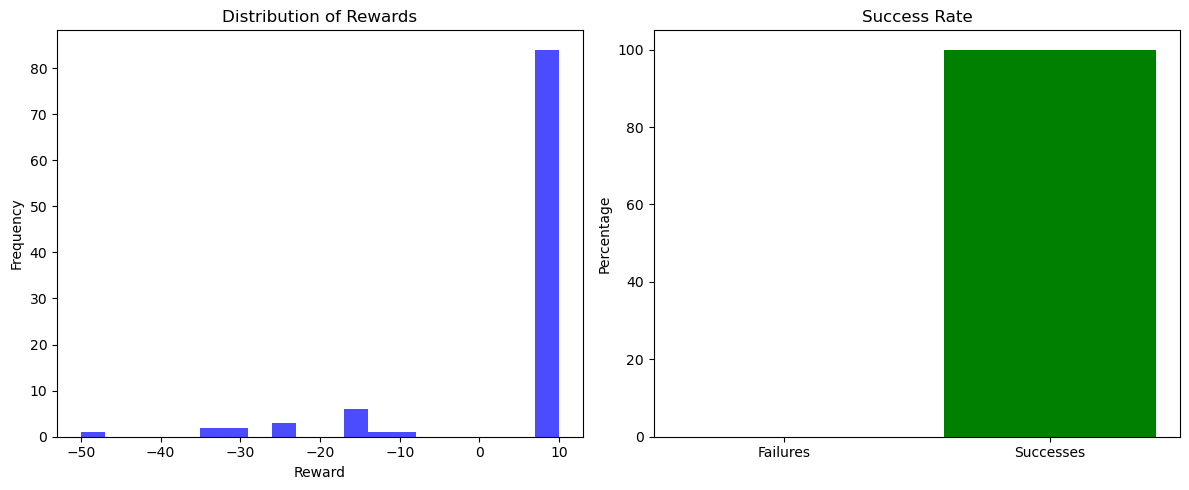

In [ ]:
rewards, successes, steps = test_model(env_capsulated, ex2_model)
visualize_results(rewards, successes, steps)

Training the agent for 800,000 more steps

In [ ]:
ppo_agent.learn(total_timesteps=800_000, reset_num_timesteps=False)

Exception ignored in: <function PluginV3.__del__ at 0x0000025BADF8E840>
Traceback (most recent call last):
  File "c:\Users\Reef\anaconda3\envs\RL\Lib\site-packages\imageio\core\v3_plugin_api.py", line 370, in __del__
    self.close()
  File "c:\Users\Reef\anaconda3\envs\RL\Lib\site-packages\imageio\plugins\pillow.py", line 144, in close
    self._flush_writer()
  File "c:\Users\Reef\anaconda3\envs\RL\Lib\site-packages\imageio\plugins\pillow.py", line 476, in _flush_writer
    if len(self.images_to_write) == 0:
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'PillowPlugin' object has no attribute 'images_to_write'


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 91.7     |
|    ep_rew_mean     | 3.87     |
| time/              |          |
|    fps             | 61       |
|    iterations      | 1        |
|    time_elapsed    | 266      |
|    total_timesteps | 1032192  |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 82.7        |
|    ep_rew_mean          | 3.36        |
| time/                   |             |
|    fps                  | 57          |
|    iterations           | 2           |
|    time_elapsed         | 565         |
|    total_timesteps      | 1048576     |
| train/                  |             |
|    approx_kl            | 0.059480704 |
|    clip_fraction        | 0.421       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.961      |
|    explained_variance   | 0.836       |
|    learning_rate        | 0.

Video test of the agent after training for 800,000 (total 1,800,000) more steps and performance statistics

In [ ]:
html_video = video_test_ex2(ppo_agent)
html_video

Mean Reward: 5.8432166666666605
Standard Deviation of Rewards: 11.427517143707226
Median Reward: 9.816666666666666
Median Number Of Steps: 5.0
Success Rate: 0.89%


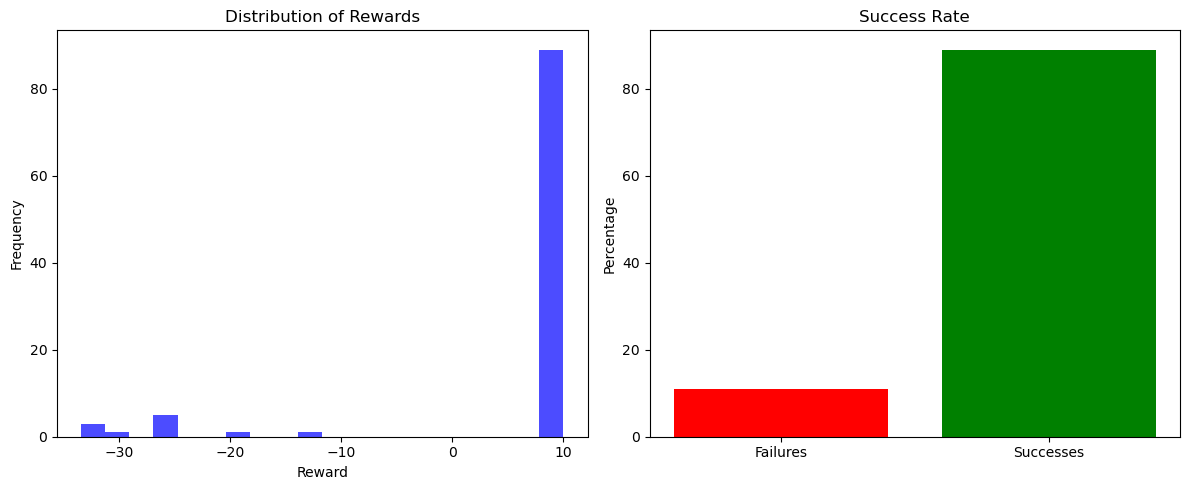

In [ ]:
rewards, successes, steps = test_model(env_capsulated, ex2_model)
visualize_results(rewards, successes, steps)

Training the agent for 500,000 more steps

In [ ]:
obs = env_capsulated.reset()
ppo_agent.learn(total_timesteps=500_000, reset_num_timesteps=False)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.9     |
|    ep_rew_mean     | 7.15     |
| time/              |          |
|    fps             | 62       |
|    iterations      | 1        |
|    time_elapsed    | 261      |
|    total_timesteps | 1835008  |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 65.7       |
|    ep_rew_mean          | 4.34       |
| time/                   |            |
|    fps                  | 59         |
|    iterations           | 2          |
|    time_elapsed         | 552        |
|    total_timesteps      | 1851392    |
| train/                  |            |
|    approx_kl            | 0.06469151 |
|    clip_fraction        | 0.395      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.967     |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.0003     |
|   

Video test of the agent after training for 500,000 (Total 2,300,000) more steps and performance statistics

In [ ]:
html_video = video_test_ex2(ppo_agent)
html_video

Mean Reward: 7.067166666666667
Standard Deviation of Rewards: 10.243289623238988
Median Reward: 9.85
Median Number Of Steps: 4.0
Success Rate: 0.93%


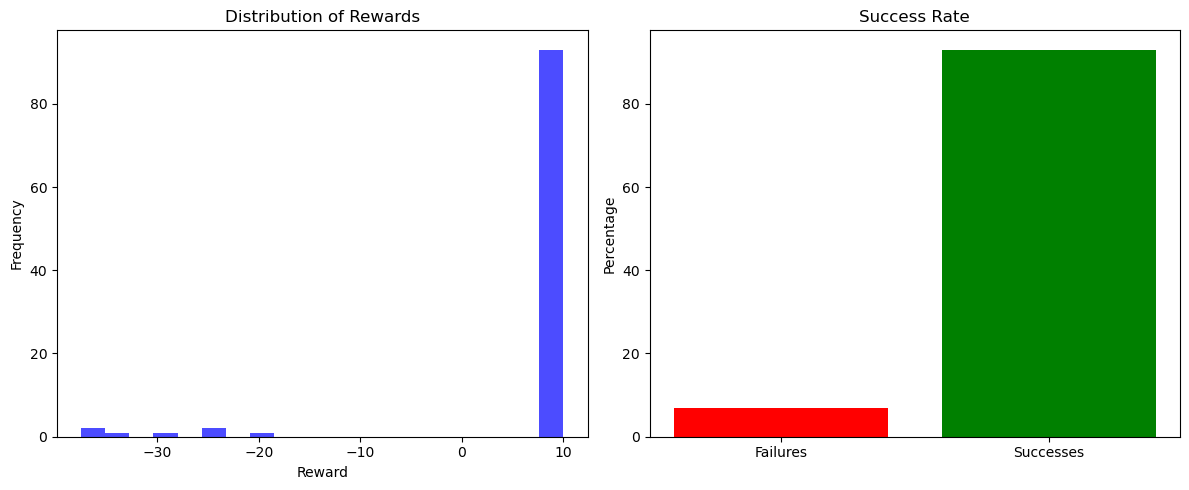

In [ ]:
rewards, successes, steps = test_model(env_capsulated, ppo_agent)
visualize_results(rewards, successes, steps)

In [ ]:
torch.save(ex2_model.policy.state_dict(), 'policy_ex2_PPO_model.pth')

Explanation in report

In [ ]:
class PolicyGradientAgent:
    def __init__(self, env, state_dim, action_dim, learning_rate=0.001, discount_factor=0.95):
        self.env = env
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.discount_factor = discount_factor

        self.policy = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Added dropout layer
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.9)

        self.episode_rewards = []
        self.episode_actions = []
        self.episode_states = []
        self.total_rewards = []


    def choose_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():  # Ensure no gradients are computed here
            action_probs = self.policy(state)

        # Normalize using softmax to ensure probabilities sum to 1 and are valid
        action_probs = torch.nn.functional.softmax(action_probs, dim=-1)

        # Additional safety: Normalize manually to avoid any numerical issues
        action_probs = action_probs / action_probs.sum()

        # Check if there are any NaNs or infs
        if not torch.all(torch.isfinite(action_probs)):
            # print("Warning: Non-finite probabilities detected. Adjusting.")
            action_probs[~torch.isfinite(action_probs)] = 1e-10  # Assign a small number to non-finite elements
            action_probs = action_probs / action_probs.sum()  # Re-normalize

        # Attempt to sample from the multinomial distribution
        try:
            action = torch.multinomial(action_probs, 1).item()
        except RuntimeError as e:
            print("Error in sampling action:", e)
            action = torch.argmax(action_probs).item()  # Fallback: Choose the most probable action

        return action

    def store_transition(self, state, action, reward):
        self.episode_states.append(state)
        self.episode_actions.append(action)
        self.episode_rewards.append(reward)

    def train_episode(self):
        # Modifications to normalization and loss calculation

        R = 0
        policy_loss = []
        returns = []
        for r in self.episode_rewards[::-1]:
            R = r + self.discount_factor * R
            returns.insert(0, R)

        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-6)  # Normalize

        for state, action, R in zip(self.episode_states, self.episode_actions, returns):
            state = torch.FloatTensor(state).unsqueeze(0)
            action_probs = self.policy(state)
            action_prob = action_probs.squeeze(0)[action]
            action_prob = torch.clamp(action_prob, 1e-10, 1.0)
            log_prob = torch.log(action_prob)
            policy_loss.append(-log_prob * R + 0.01 * -(action_probs * torch.log(action_probs)).sum())  # Entropy term added

        if policy_loss:
            self.optimizer.zero_grad()
            policy_loss = torch.stack(policy_loss).sum()
            policy_loss.backward()
            self.optimizer.step()
            self.scheduler.step()

        total_reward = sum(self.episode_rewards)
        self.total_rewards.append(total_reward)
        self.episode_rewards = []
        self.episode_actions = []
        self.episode_states = []

    def reward_shaping(self, action, box_location, new_box_location, player_location, new_player_location, box_target, reward):
        if box_location is None:
            box_location = box_target
        if box_target is None:
            box_target = box_location
        if new_box_location is None:
            new_box_location = box_target
            reward += 10

        current_box_distance = np.sum(np.abs(np.array(box_location) - np.array(box_target)))
        new_box_distance = np.sum(np.abs(np.array(new_box_location) - np.array(box_target)))

        if new_box_distance < current_box_distance:
            reward += 2  # Positive reward for moving the box closer
        elif new_box_distance > current_box_distance:
            reward -= 2  # Negative reward for moving the box away

        current_player_distance = np.sum(np.abs(np.array(player_location) - np.array(box_location)))
        new_player_distance = np.sum(np.abs(np.array(new_player_location) - np.array(new_box_location)))

        if new_player_distance < current_player_distance:
            reward += 0.5  # Reward for moving closer to the box
        elif new_player_distance > current_player_distance:
            reward -= 0.5  # Penalty for moving away from the box

        if new_box_distance == current_box_distance:
            reward -= 1

        return reward

    def train(self, episodes):
        for e in range(episodes):
            state = self.env.reset()
            box_location = find_box_location(self.env)
            player_location = find_player_location(self.env)
            state = self.env.render('tiny_rgb_array').flatten()
            box_target = find_target_location(self.env)
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                new_box_location = find_box_location(self.env)
                new_player_location = find_player_location(self.env)
                next_state = self.env.render('tiny_rgb_array').flatten()

                reward = self.reward_shaping(action, box_location, new_box_location, player_location, new_player_location, box_target, reward)
                self.store_transition(state, action, reward)
                state = next_state

            self.train_episode()

            print(f'Episode {e} completed.')
            if (e + 1) % 10 == 0:
                print(f"Episode: {e+1}/{episodes}, Average Reward: {np.mean(self.total_rewards)}")

            if e == 249:
                torch.save(self.policy.state_dict(), 'policy_gradient_model.pth')
                print(f"Model saved after episode {e+1}")

            if e == 499:
                torch.save(self.policy.state_dict(), 'policy_gradient_model_completed.pth')
                print(f"Model saved after episode {e+1}")

        print("Training completed.")


In [ ]:
env = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1, max_steps=500)
gradient_agent = PolicyGradientAgent(env, state_dim=7*7*3, action_dim=env.action_space.n)
gradient_agent.train(5000)
test_agent2(gradient_agent, env)

Episode 0 completed.
Episode 1 completed.
Episode 2 completed.
Episode 3 completed.
Episode 4 completed.
Episode 5 completed.
Episode 6 completed.
Episode 7 completed.
Episode 8 completed.
Episode 9 completed.
Episode: 10/5000, Average Reward: -196.49000000000342
Episode 10 completed.
Episode 11 completed.
Episode 12 completed.
Episode 13 completed.
Episode 14 completed.
Episode 15 completed.
Episode 16 completed.
Episode 17 completed.
Episode 18 completed.
Episode 19 completed.
Episode: 20/5000, Average Reward: -103.98000000000238
Episode 20 completed.
Episode 21 completed.
Episode 22 completed.
Episode 23 completed.
Episode 24 completed.
Episode 25 completed.
Episode 26 completed.
Episode 27 completed.
Episode 28 completed.
Episode 29 completed.
Episode: 30/5000, Average Reward: -69.56666666666868
Episode 30 completed.
Episode 31 completed.
Episode 32 completed.
Episode 33 completed.
Episode 34 completed.
Episode 35 completed.
Episode 36 completed.
Episode 37 completed.
Episode 38 co

C:\Users\Reef\AppData\Local\Temp\ipykernel_18668\1839154852.py:66: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1808.)
  returns = (returns - returns.mean()) / (returns.std() + 1e-6)  # Normalize


Episode 78 completed.
Episode 79 completed.
Episode: 80/5000, Average Reward: -137.98750000000263
Episode 80 completed.
Episode 81 completed.
Episode 82 completed.
Episode 83 completed.
Episode 84 completed.
Episode 85 completed.
Episode 86 completed.
Episode 87 completed.
Episode 88 completed.
Episode 89 completed.
Episode: 90/5000, Average Reward: -155.27111111111378
Episode 90 completed.
Episode 91 completed.
Episode 92 completed.
Episode 93 completed.
Episode 94 completed.
Episode 95 completed.
Episode 96 completed.
Episode 97 completed.
Episode 98 completed.
Episode 99 completed.
Episode: 100/5000, Average Reward: -171.49600000000268
Episode 100 completed.
Episode 101 completed.
Episode 102 completed.
Episode 103 completed.
Episode 104 completed.
Episode 105 completed.
Episode 106 completed.
Episode 107 completed.
Episode 108 completed.
Episode 109 completed.
Episode: 110/5000, Average Reward: -173.87272727272992
Episode 110 completed.
Episode 111 completed.
Episode 112 completed.

In [ ]:
def test_agent2(agent, env, episodes=100):
    total_rewards = []
    action_counts = {action: 0 for action in range(env.action_space.n)}
    episode_lengths = []
    successes = 0

    for e in range(episodes):
        state = env.reset()
        state = env.render('tiny_rgb_array').flatten()
        total_reward = 0
        done = False
        steps = 0

        while not done:
            action = agent.choose_action(state)  # Ensure to set the agent in testing mode
            action_counts[action] += 1
            next_state, reward, done, _ = env.step(action)
            next_state = env.render('tiny_rgb_array').flatten()
            total_reward += reward
            state = next_state
            steps += 1

        total_rewards.append(total_reward)
        episode_lengths.append(steps)
        if steps < 500:  # Check if the episode is successful
            successes += 1

    # Statistical Metrics
    mean_reward = np.mean(total_rewards)
    median_reward = np.median(total_rewards)
    std_dev_reward = np.std(total_rewards)
    max_reward = np.max(total_rewards)
    min_reward = np.min(total_rewards)
    success_rate = successes / episodes * 100  # Calculate success rate

    # Plotting Results
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(total_rewards, label='Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards over Episodes')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.bar(action_counts.keys(), action_counts.values())
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.title('Action Distribution')

    plt.tight_layout()
    plt.show()

    print("\n--- Testing Summary ---")
    print(f"Mean Total Reward: {mean_reward:.2f}")
    print(f"Median Total Reward: {median_reward:.2f}")
    print(f"Standard Deviation of Total Rewards: {std_dev_reward:.2f}")
    print(f"Maximum Total Reward: {max_reward}")
    print(f"Minimum Total Reward: {min_reward}")
    print("Action Distribution:", action_counts)
    print("Average Episode Length:", np.mean(episode_lengths))
    print(f"Success Rate: {success_rate:.2f}% (Episodes finished in less than 500 steps)")

### EX2 - Video test

In [ ]:
env = sok_2
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

## EX3 - PUSH & PULL - TWO BOXES

In [ ]:
#=============== DO NOT DELETE ===============
sok_3 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=2 ,max_steps=500)
# ============================================

In [ ]:
screen = sok_3.render(mode='rgb_array')
plt.imshow(sok_3.render('rgb_array'))
print_env_det(sok_3)

### EX3 - Video test

In [ ]:
env = sok_3
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)